In [27]:
from keras.datasets import cifar10
from keras.utils import np_utils
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import sys
import keras

### Loading the data

In [28]:
# import dataset from keras
(X_train,y_train), (X_test, y_test) = cifar10.load_data()

In [29]:
# explore the data
print("Training Images: {}".format(X_train.shape))
print("Testing Images: {}".format(X_test.shape))

Training Images: (50000, 32, 32, 3)
Testing Images: (10000, 32, 32, 3)


In [30]:
# a single image
print(X_train[0].shape)

(32, 32, 3)


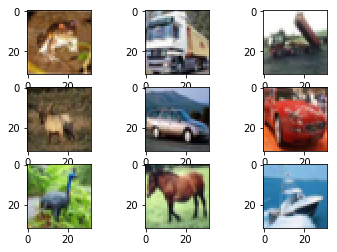

In [31]:
# create a grid of 3 X 3 images
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    img = X_train[i]
    plt.imshow(img)

plt.show()

### Preprocessing the data

In [32]:
# fix a random seed to reproduce same results
seed = 6
np.random.seed(seed)

# load the data again
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# normalize the input values from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

print(X_train[0])

[[[0.23137255 0.24313726 0.24705882]
  [0.16862746 0.18039216 0.1764706 ]
  [0.19607843 0.1882353  0.16862746]
  ...
  [0.61960787 0.5176471  0.42352942]
  [0.59607846 0.49019608 0.4       ]
  [0.5803922  0.4862745  0.40392157]]

 [[0.0627451  0.07843138 0.07843138]
  [0.         0.         0.        ]
  [0.07058824 0.03137255 0.        ]
  ...
  [0.48235294 0.34509805 0.21568628]
  [0.46666667 0.3254902  0.19607843]
  [0.47843137 0.34117648 0.22352941]]

 [[0.09803922 0.09411765 0.08235294]
  [0.0627451  0.02745098 0.        ]
  [0.19215687 0.10588235 0.03137255]
  ...
  [0.4627451  0.32941177 0.19607843]
  [0.47058824 0.32941177 0.19607843]
  [0.42745098 0.28627452 0.16470589]]

 ...

 [[0.8156863  0.6666667  0.3764706 ]
  [0.7882353  0.6        0.13333334]
  [0.7764706  0.6313726  0.10196079]
  ...
  [0.627451   0.52156866 0.27450982]
  [0.21960784 0.12156863 0.02745098]
  [0.20784314 0.13333334 0.07843138]]

 [[0.7058824  0.54509807 0.3764706 ]
  [0.6784314  0.48235294 0.16470589]


In [33]:
# print class label shape
print(y_train.shape)
print(y_train[0])

(50000, 1)
[6]



The class labels are a single integer value (0-9). What we want is a one-hot vector of length ten. For example, the class label of 6 should be denoted [0, 0, 0, 0, 0, 0, 1, 0, 0, 0].


In [34]:
# hot encode outputs
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)
num_class = Y_train.shape[1]
print(num_class)

print(Y_train.shape)
print(Y_train[0])

10
(50000, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


### Building the All-CNN

Using the 2015 ICLR paper, "Striving For Simplicity: The All Convolutional Net" (https://arxiv.org/pdf/1412.6806.pdf) as a reference, we can implement the All-CNN network in Keras.

In [35]:
# importing necessary layers
from keras.models import Sequential
from keras.layers import Dropout, Activation, Conv2D, GlobalAveragePooling2D
from keras.optimizers import SGD

In [36]:
# defining the model function

def allcnn(weights = None):
    # define model type - Sequential
    model = Sequential()
    
    # add model layers
    model.add(Conv2D(96, (3, 3), padding = 'same', input_shape = (32,32,3)))
    model.add(Activation('relu'))
    model.add(Conv2D(96, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(96, (3, 3), padding = 'same', strides = (2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(192, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (3, 3), padding = 'same', strides = (2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(192, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (1, 1), padding = 'valid'))
    model.add(Activation('relu'))
    model.add(Conv2D(10, (1, 1), padding = 'valid'))
    
    # add Global Average Pooling Layer with Softmax activation
    model.add(GlobalAveragePooling2D())
    model.add(Activation('softmax'))
    
    # load the weights
    if weights:
        model.load_weights(weights)
    
    # return the model
    return model

### Defining Parameters and Training the model

In [37]:
# define hyper parameters
learning_rate = 0.01
weight_decay = 1e-6
momentum = 0.9

# build model
model = allcnn()

# define optimizer and compile model
sgd = SGD(lr = learning_rate, decay=weight_decay, momentum=momentum, nesterov=True)
model.compile(loss ='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# print model summary
print (model.summary())

# define aditional training parameters
epochs = 350
batch_size = 32

# fit the model
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=batch_size, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_116 (Conv2D)          (None, 32, 32, 96)        2688      
_________________________________________________________________
activation_90 (Activation)   (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 32, 32, 96)        83040     
_________________________________________________________________
activation_91 (Activation)   (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 16, 16, 96)        83040     
_________________________________________________________________
dropout_27 (Dropout)         (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 16, 16, 192)       166080    
__________

KeyboardInterrupt: 

It's apparent that training this deep convolutional neural network is going to take a long time (500 hours), which is not surprising considering the network has about 1.3 million parameters. 
Save some time by loading pre-trained weights for the All-CNN network. Using these weights, we can evaluate the performance of the All-CNN network on the testing dataset.

In [39]:
# hyper parameters
learning_rate = 0.01
weight_decay = 1e-6
momentum = 0.9

# define weights and build model
weights = 'all_cnn_weights_0.9088_0.4994.hdf5'
model = allcnn(weights)

# define optimizer and compile model
sgd = SGD(lr=learning_rate, decay=weight_decay, momentum=momentum, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# print model summary
print (model.summary())

# test the model with pretrained weights
scores = model.evaluate(X_test, Y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_134 (Conv2D)          (None, 32, 32, 96)        2688      
_________________________________________________________________
activation_104 (Activation)  (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 32, 32, 96)        83040     
_________________________________________________________________
activation_105 (Activation)  (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 16, 16, 96)        83040     
_________________________________________________________________
dropout_31 (Dropout)         (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 16, 16, 192)       166080    
__________

### Making Predictions

In [40]:
# make a dictionary of class labels and names
classes = range(0,10)

names = ['airplane',
        'automobile',
        'bird',
        'cat',
        'deer',
        'dog',
        'frog',
        'horse',
        'ship',
        'truck']

# zip the names and classes to make a dictionary of class labels
class_labels = dict(zip(classes, names))
print(class_labels)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [45]:
# generate batch of nine images to predict
batch = X_test[100:109]
labels = np.argmax(Y_test[100:109], axis = -1)

# make predictions
predictions = model.predict(batch, verbose = 1)

9/9 [==============================] - 0s 11ms/step


In [46]:
# print predictions
print (predictions)

[[4.56472342e-18 1.05810246e-20 1.89232421e-10 2.14114854e-11
  9.99999285e-01 2.80375247e-07 3.14786662e-13 4.23812452e-07
  1.36995572e-19 1.20971122e-18]
 [2.11912264e-16 2.03867016e-17 1.56727065e-09 5.35816639e-07
  1.62562644e-10 9.99999404e-01 1.67125547e-09 2.07823074e-08
  3.65486119e-15 3.51288651e-16]
 [1.27203225e-30 5.02736423e-28 5.15396277e-24 3.60512695e-21
  1.08752228e-27 8.15215322e-22 1.00000000e+00 1.10509080e-27
  6.19246192e-32 1.22743333e-23]
 [1.51438294e-16 4.76690539e-18 2.25836949e-09 1.00000000e+00
  4.34811284e-11 1.68841135e-12 4.53171246e-13 2.66869536e-16
  7.26597001e-19 6.20504176e-17]
 [8.24998297e-36 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 9.35651890e-36
  8.68659706e-30 8.21906932e-22]
 [5.96992736e-24 1.00000000e+00 7.54846902e-27 8.02280708e-27
  1.97139506e-30 2.73385063e-29 7.21873855e-31 5.56797325e-27
  1.61868680e-26 1.19061282e-13]
 [6.45635478e-18 2.96424244e-20 1.00464758e-11 9.99999881e

In [48]:
# use np.argmax() to convert class probabilities to class labels
class_result = np.argmax(predictions, axis = -1)
print(class_result)

[4 5 6 3 1 1 3 6 8]


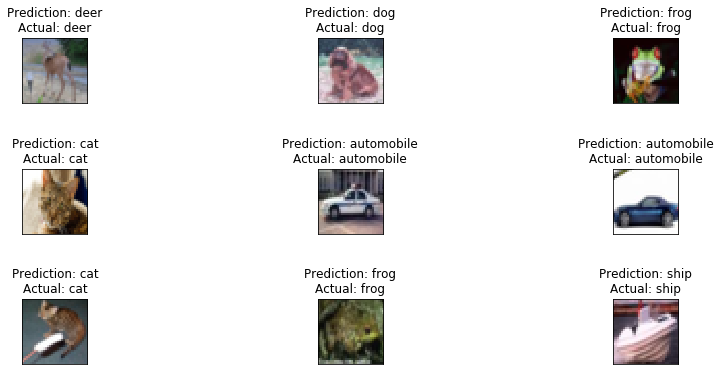

In [50]:
# create a grid of 3x3 images
fig, axs = plt.subplots(3, 3, figsize = (15, 6))
fig.subplots_adjust(hspace = 1)
axs = axs.flatten()

for i, img in enumerate(batch):

    # determine label for each prediction, set title
    for key, value in class_labels.items():
        if class_result[i] == key:
            title = 'Prediction: {}\nActual: {}'.format(class_labels[key], class_labels[labels[i]])
            axs[i].set_title(title)
            axs[i].axes.get_xaxis().set_visible(False)
            axs[i].axes.get_yaxis().set_visible(False)
            
    # plot the image
    axs[i].imshow(img)
    
# show the plot
plt.show()